In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px

from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

from sklearn.mixture import GaussianMixture

# CLUSTERING
Note: we didn't include normalizing the data, from the presentation since we wanted to highlight the similarities/differences of the 2 models

## Importing the Data
Upon importing the data, houses and condomenium properties are separated since based on the EDA, both have different ranges of prices and total developed. Combining them will not benefit the overall result of the cluster.

In [2]:
df = pd.read_json('cleaned_data.json')
condo_df = df[df['Type'] == 'Condo']
house_df = df[df['Type'] == 'House']
df.head()

,Name,Address,Author,Price,Bedrooms,Showers,Parking,Furnish,Total Developed,Features,...,Nearby Places,URL,Timestamp,City,Region,Island,Type,NFeatures,NFacilities,NNearby Places
0,"3 BR Condo in The Grand Midori Ortigas, Pasig",,"Federal Land, Inc.",29700000,3,3.0,2,0,107.0,"[Ensuite, Range Hood, Stove/Burner]",...,"[School, Hospital]",https://propertyaccess.ph/property/3-br-condo-...,2022-10-23,Pasig,National Capital Region,Luzon,Condo,3,11,2
1,"1 Bedroom Condo in The Grand Midori Ortigas, P...",,"Federal Land, Inc.",10200000,1,1.0,0,0,46.0,[Fiber ready],...,"[School, Hospital]",https://propertyaccess.ph/property/1br-condo-i...,2022-10-23,Pasig,National Capital Region,Luzon,Condo,1,11,2
2,"3 Bedroom Condo in Aurelia Residences, Taguig","McKinley Parkway, Taguig, Metro Manila",Shang Properties,107300000,3,4.0,2,0,242.0,"[Central air conditioning, Balcony, Built-in w...",...,"[School, Hospital, Mall, Transportation hub]",https://propertyaccess.ph/property/3-bedroom-c...,2022-10-23,Taguig,National Capital Region,Luzon,Condo,10,15,4
3,3 Bedroom Condo in Shang Residences at Wack Wa...,"Wack Wack Road, Mandaluyong, Metro Manila",Shang Properties,54500000,3,4.0,3,0,231.0,"[Central air conditioning, Balcony, Built-in w...",...,"[School, Hospital, Mall, Transportation hub]",https://propertyaccess.ph/property/3-bedroom-c...,2022-10-23,Mandaluyong,National Capital Region,Luzon,Condo,9,16,4
4,"2BR Condo in Residences at The Galleon, Pasig",,Ortigas Land,41500000,2,2.0,2,0,109.0,"[Central air conditioning, Balcony, Built-in w...",...,"[School, Hospital, Mall, Transportation hub]",https://propertyaccess.ph/property/2br-condo-i...,2022-10-23,Pasig,National Capital Region,Luzon,Condo,7,14,4


In [3]:
# data to be used for clustering
data = df[['Price', 'Bedrooms', 'Showers', 'Parking', 'Total Developed']]
condo_data = condo_df[['Price', 'Bedrooms', 'Showers', 'Parking', 'Total Developed']]
house_data = house_df[['Price', 'Bedrooms', 'Showers', 'Parking', 'Total Developed']]

## K Means Clustering
### Condos Actual Data
#### Getting appropriate number of clusters

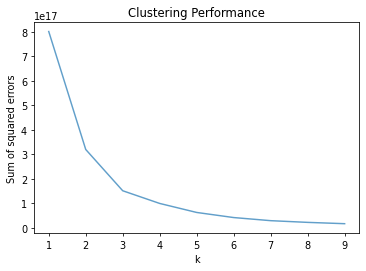

In [4]:
num_clusters = np.arange(1,10)

sum_of_squared_errors = []

for k in num_clusters:
    km = KMeans(n_clusters=k, random_state=25)
    km = km.fit(condo_data)
    sum_of_squared_errors.append(km.inertia_)
    
alpha = 0.7
fig, ax = plt.subplots(1,1, dpi=70)
lns1 = ax.plot(num_clusters, sum_of_squared_errors, alpha=alpha, label='Sum of Squared Errors')
ax.set_ylabel('Sum of squared errors')

plt.xlabel('k')
plt.title('Clustering Performance')
plt.show()

Using the elbow method, the k value is chosen to be **3**.

#### Defining the model

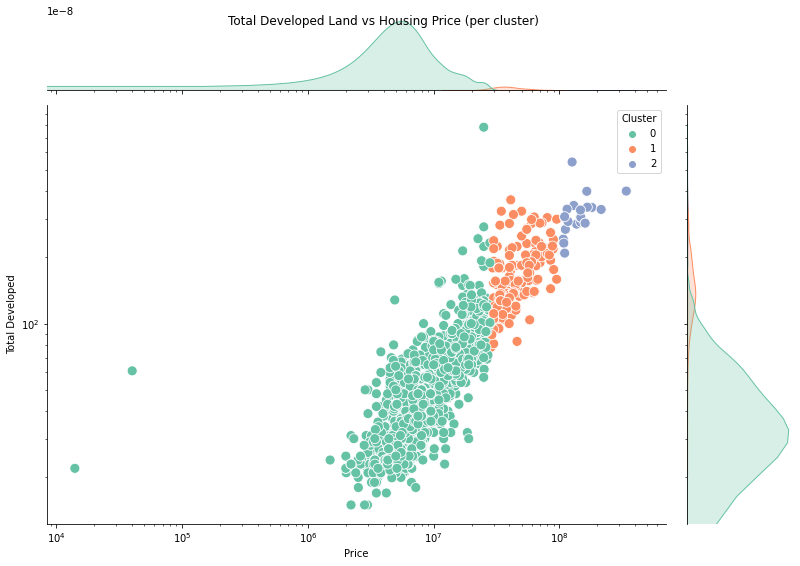

In [5]:
kmeansDF = condo_df.copy()
km = KMeans(n_clusters=3, random_state=25)
km = km.fit(condo_data)
clusters = km.fit_predict(condo_data)
kmeansDF['Cluster'] = clusters

g = sns.jointplot(data=kmeansDF,s=100, x='Price', y='Total Developed', hue='Cluster', palette="Set2")

g.fig.suptitle("Total Developed Land vs Housing Price (per cluster)")
g.fig.set_size_inches((12, 8)) 
g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')

#### Results per cluster
##### Number of items per cluster

Text(0, 0.5, 'Count')

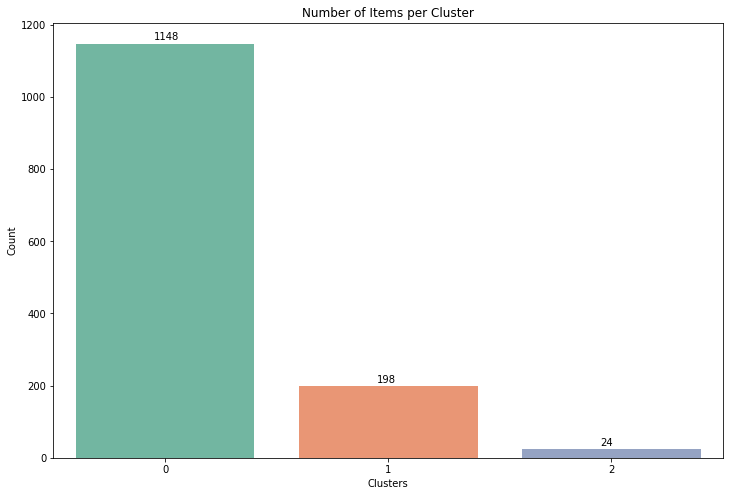

In [6]:
_ = plt.figure(figsize=(12, 8))

g = sns.countplot(x='Cluster', data=kmeansDF, palette="Set2")
for p in g.patches:
    g.annotate('{}'.format(p.get_height()), (p.get_x()+.35, p.get_height()+10))

plt.title("Number of Items per Cluster")
plt.xlabel("Clusters")
plt.ylabel("Count")

##### Total Developed vs Price per Cluster

Text(0.5, 1.0, 'Prices per Cluster')

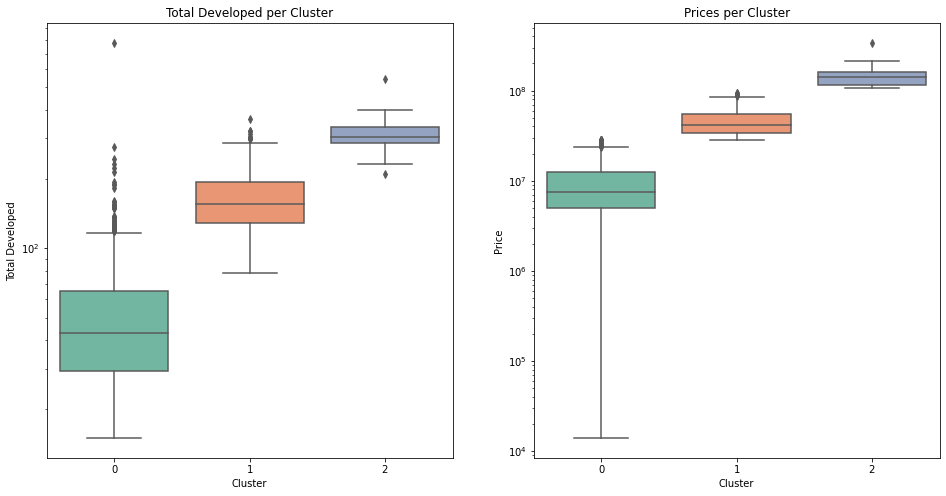

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.boxplot(data=kmeansDF, x='Cluster', y='Total Developed', palette='Set2', ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_title("Total Developed per Cluster")

sns.boxplot(data=kmeansDF, x='Cluster', y='Price', palette='Set2', ax=ax[1])
ax[1].set_yscale('log')
ax[1].set_title("Prices per Cluster")

In [8]:
kmeansDF.groupby('Cluster').median()[['Price', 'Total Developed']]

,Price,Total Developed
Cluster,,
0,7500000.0,43.0
1,41964000.0,155.5
2,141925000.0,304.0


By comparing the clusters through their boxplots, we can see the price and area ranges of each cluster. We can see that:
1. Cluster 0 - has the lowest prices and total developed area values and range _(low-end condominiums)_
2. Cluster 1 - has middle prices and total developed area  _(mid-end condominiums)_
3. Cluster 2 - has highest prices and total developed area _(high-end condominiums)_

##### Total Bedrooms vs Showers

Text(0.5, 1.0, 'Showers per Cluster')

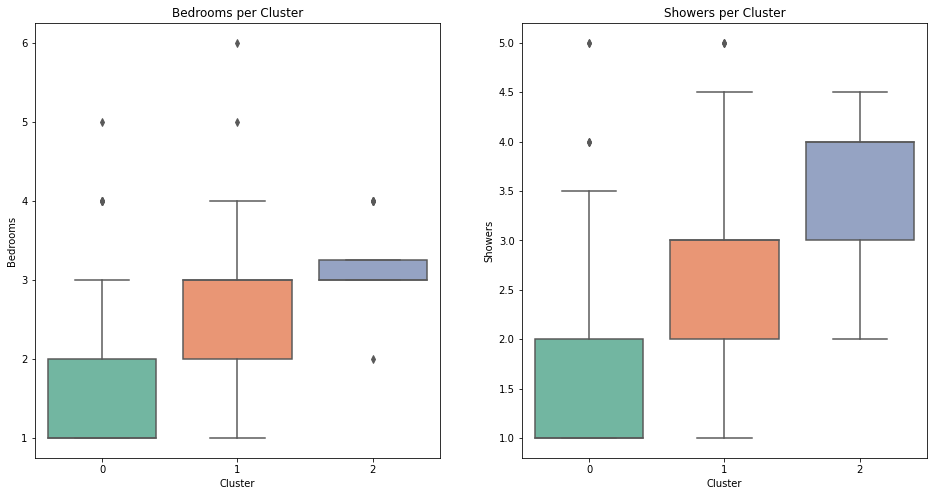

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.boxplot(data=kmeansDF, x='Cluster', y='Bedrooms', palette='Set2', ax=ax[0])
ax[0].set_title("Bedrooms per Cluster")

sns.boxplot(data=kmeansDF, x='Cluster', y='Showers', palette='Set2', ax=ax[1])
ax[1].set_title("Showers per Cluster")

In [10]:
kmeansDF.groupby('Cluster').median()[['Bedrooms', 'Showers', 'Parking']]

,Bedrooms,Showers,Parking
Cluster,,,
0,1.0,1.0,0.0
1,3.0,3.0,2.0
2,3.0,4.0,3.0


By looking at the amount of bedrooms and showers of properties in each cluster, we can see that:
1. **Low-end** condominiums typically only has _1-2 bedrooms with 1-2 showers_
2. **Mid-end** condominiums typically have _2-3 bedrooms with 2-3 showers_.
3. **High-end** condominiums typically have _3 bedrooms with 3-4 showers_.

##### Most Common Location per Cluster

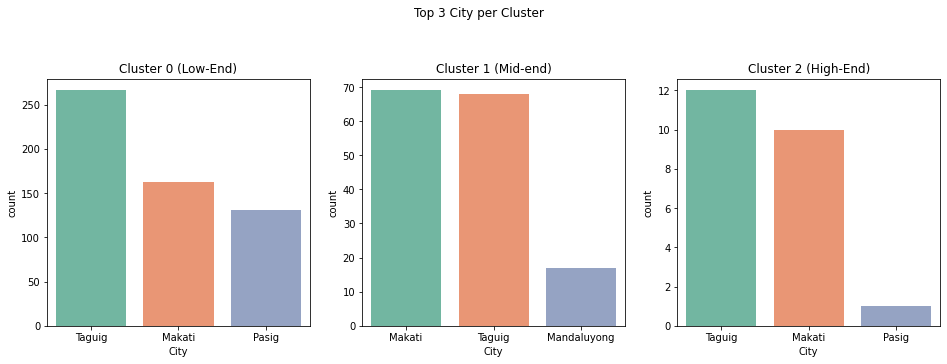

In [11]:
descriptions = ['Low-End', 'Mid-end', 'High-End']

fig = plt.figure(figsize=(16, 10))

fig.suptitle('Top 3 City per Cluster')

for cluster in range(3):
    fig.add_subplot(2, 3, cluster + 1)
    g = sns.countplot(x='City', data=kmeansDF[kmeansDF['Cluster'] == cluster], order=kmeansDF[kmeansDF['Cluster'] == cluster]['City'].value_counts().iloc[:3].index, palette="Set2")
    
    plt.title("Cluster %d (%s)" % (cluster, descriptions[cluster]))

We can see that the **Taguig** is the region with the **most the number of condominiums listed for the low-end and high-end clusters**. With Makati leading the middle-end clusters.

### Houses Actual Data
#### Getting appropriate number of clusters

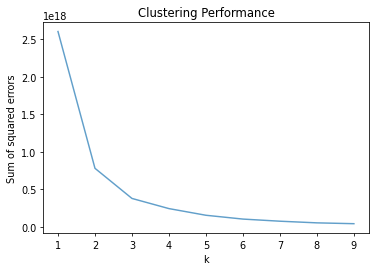

In [12]:
num_clusters = np.arange(1,10)

sum_of_squared_errors = []

for k in num_clusters:
    km = KMeans(n_clusters=k, random_state=25)
    km = km.fit(house_data)
    sum_of_squared_errors.append(km.inertia_)
    
alpha = 0.7
fig, ax = plt.subplots(1,1, dpi=70)
lns1 = ax.plot(num_clusters, sum_of_squared_errors, alpha=alpha, label='Sum of Squared Errors')
ax.set_ylabel('Sum of squared errors')

plt.xlabel('k')
plt.title('Clustering Performance')
plt.show()

Using the elbow method, the k value is chosen to be **3**.

#### Defining the model

In [13]:
kmeansDF = house_df.copy()
km = KMeans(n_clusters=3, random_state=25)
km = km.fit(house_data)
clusters = km.fit_predict(house_data)
kmeansDF['Cluster'] = clusters

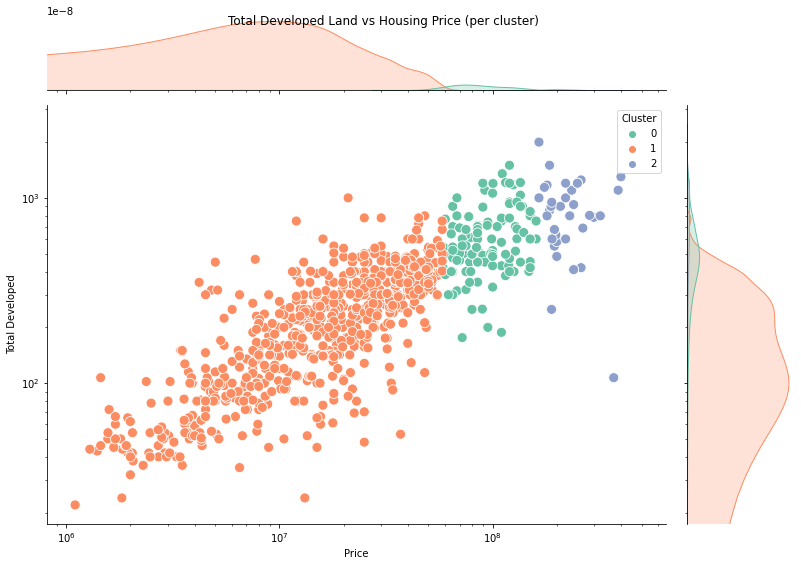

In [14]:
g = sns.jointplot(data=kmeansDF,s=100, x='Price', y='Total Developed', hue='Cluster', palette="Set2")

g.fig.suptitle("Total Developed Land vs Housing Price (per cluster)")
g.fig.set_size_inches((12, 8)) 
g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')

#### Results per cluster
##### Number of items per cluster

Text(0, 0.5, 'Count')

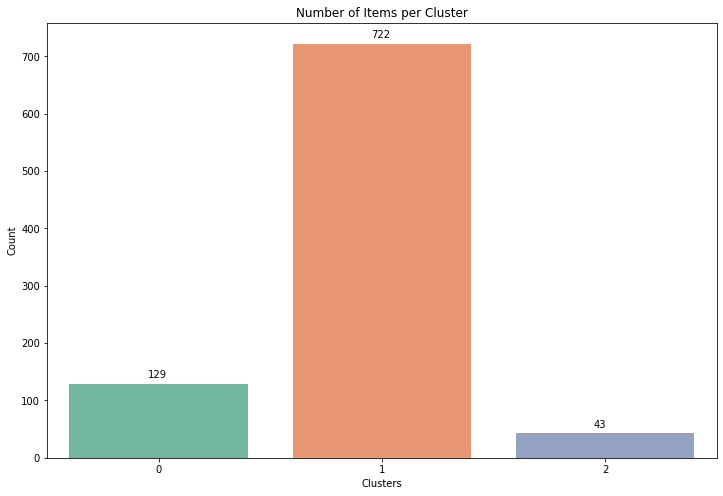

In [15]:
_ = plt.figure(figsize=(12, 8))

g = sns.countplot(x='Cluster', data=kmeansDF, palette="Set2")
for p in g.patches:
    g.annotate('{}'.format(p.get_height()), (p.get_x()+.35, p.get_height()+10))

plt.title("Number of Items per Cluster")
plt.xlabel("Clusters")
plt.ylabel("Count")

##### Total Developed vs Price per Cluster

Text(0.5, 1.0, 'Prices per Cluster')

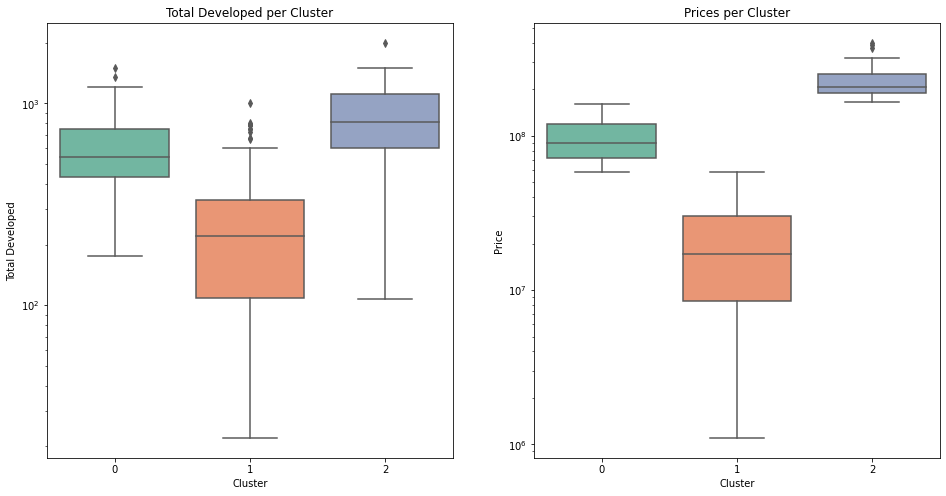

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.boxplot(data=kmeansDF, x='Cluster', y='Total Developed', palette='Set2', ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_title("Total Developed per Cluster")

sns.boxplot(data=kmeansDF, x='Cluster', y='Price', palette='Set2', ax=ax[1])
ax[1].set_yscale('log')
ax[1].set_title("Prices per Cluster")

In [17]:
kmeansDF.groupby('Cluster').median()[['Price', 'Total Developed']]

,Price,Total Developed
Cluster,,
0,90000000.0,540.0
1,17137500.0,220.0
2,208000000.0,805.0


By comparing the clusters through their boxplots, we can see the price and area ranges of each cluster. We can see that:
1. Cluster 0 - has the lowest prices and total developed area values and range _(low-end houses)_
2. Cluster 1 - has middle prices and total developed area  _(mid-end houses)_
3. Cluster 2 - has highest prices and total developed area _(high-end houses)_

##### Total Bedrooms vs Showers

Text(0.5, 1.0, 'Showers per Cluster')

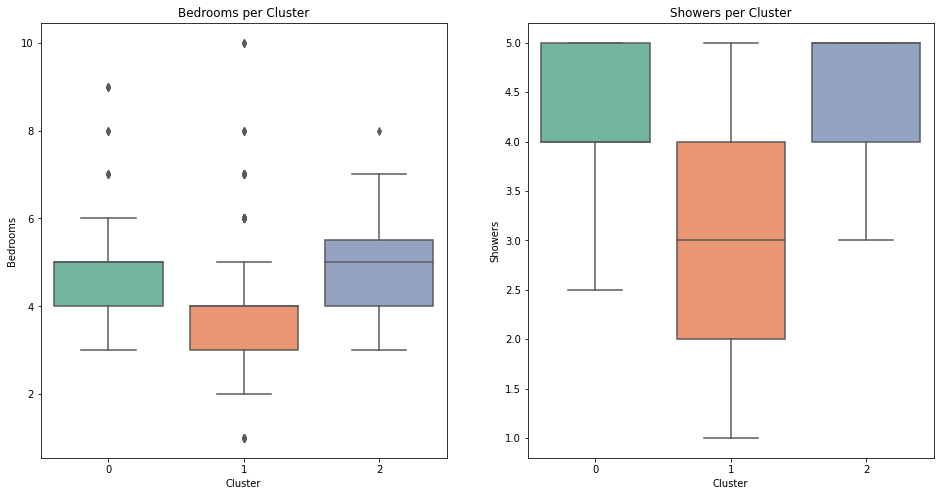

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.boxplot(data=kmeansDF, x='Cluster', y='Bedrooms', palette='Set2', ax=ax[0])
ax[0].set_title("Bedrooms per Cluster")

sns.boxplot(data=kmeansDF, x='Cluster', y='Showers', palette='Set2', ax=ax[1])
ax[1].set_title("Showers per Cluster")

In [19]:
kmeansDF.groupby('Cluster').median()[['Bedrooms', 'Showers', 'Parking']]

,Bedrooms,Showers,Parking
Cluster,,,
0,5.0,4.0,4.0
1,4.0,3.0,2.0
2,5.0,5.0,4.0


By looking at the amount of bedrooms and showers of properties in each cluster, we can see that:
1. **Low-end** houses typically only has _3-4 bedrooms with 2-4 showers_
2. The **Mid-end** houses typically have _4-5 bedrooms with 4-5 showers_.
3. The **High-end** houses typically have _4-5 bedrooms with 4-5 showers_.

##### Most Common Location per Cluster

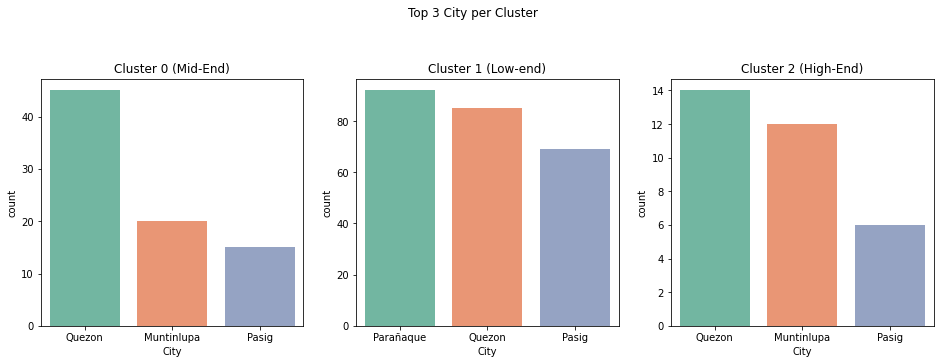

In [20]:
descriptions = ['Mid-End', 'Low-end', 'High-End']

fig = plt.figure(figsize=(16, 10))

fig.suptitle('Top 3 City per Cluster')

for cluster in range(3):
    fig.add_subplot(2, 3, cluster + 1)
    g = sns.countplot(x='City', data=kmeansDF[kmeansDF['Cluster'] == cluster], order=kmeansDF[kmeansDF['Cluster'] == cluster]['City'].value_counts().iloc[:3].index, palette="Set2")
    
    plt.title("Cluster %d (%s)" % (cluster, descriptions[cluster]))

We can see that the **Parañaque** is the area with the **most number of low-end houses**, while **Quezon** has the **most number of mid-end and high-end houses**. The 3rd city is Pasig.

### KMeans Findings

**Condos**
- Condos: The overall trend of the three clusters are consistent with each other following the 3 major groups: low-end condos, mid-end condos, and high-end condos
- For both cases, Taguig was found to have the most low-end and high-end condos, while Makati was found to have the most mid-end condos

**Houses**
- The houses have a wider range of number of bedrooms and showers
- The three main clusters are: low-end houses, mid-end houses, and high-end houses

## Gaussian 

### Condos

#### Getting appropriate number of clusters
To get this, the elbow method will be utilized, however the values that will be used would be the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) scores of each components.

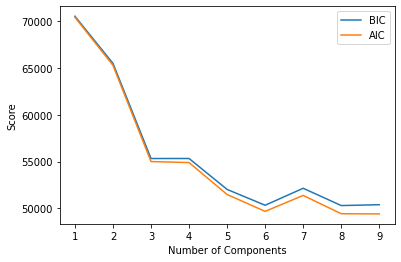

In [21]:
# check AIC and BIC as a function of number of components
N = np.arange(1,10)
models = [GaussianMixture(n,covariance_type='full',
          random_state=0).fit(condo_data) for n in N]
plt.plot(N, [m.bic(condo_data) for m in models], label='BIC')
plt.plot(N, [m.aic(condo_data) for m in models], label='AIC')
plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('Score');

Both AIC, and BIC values shows us the **3** is the best value for n_components.

#### Defining the Model

<Figure size 864x576 with 0 Axes>

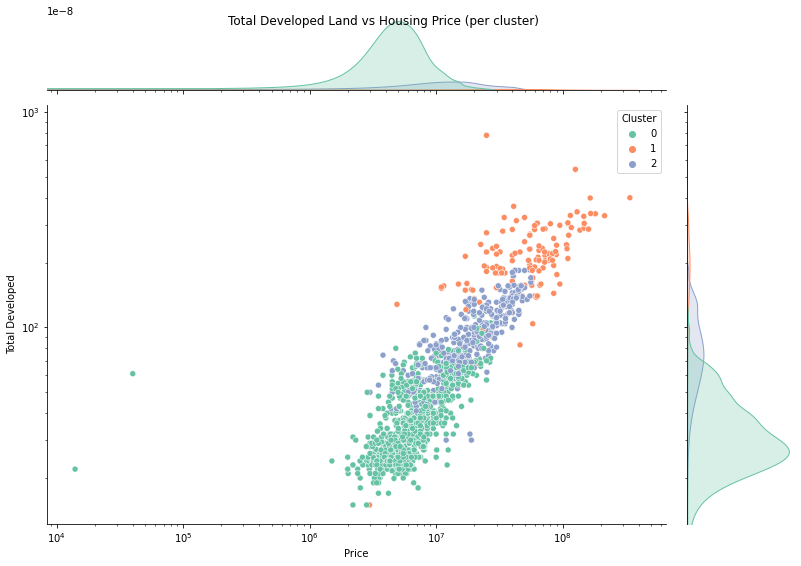

In [22]:
# define the model
model = GaussianMixture(n_components=3, covariance_type='full', random_state=0).fit(condo_data)
# assign a cluster to each example
yhat = model.predict(condo_data)

gaussianDF = condo_df.copy()

gaussianDF['Cluster'] = yhat

_ = plt.figure(figsize=(12, 8))

g = sns.jointplot(data=gaussianDF, x="Price", y="Total Developed", hue="Cluster", palette='Set2')

g.fig.suptitle("Total Developed Land vs Housing Price (per cluster)")
g.fig.set_size_inches((12, 8)) 
g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')

By looking at the chart, we can see the relationship of the different clusters from one another based on their Total Area (in sqm) vs the Selling price of the properties within those clusters.

#### Results per Cluster
##### Number of Items per Cluster

Text(0, 0.5, 'Count')

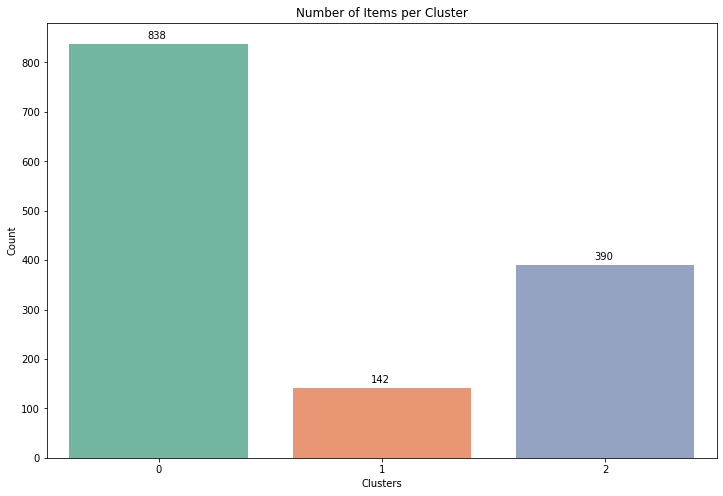

In [23]:
_ = plt.figure(figsize=(12, 8))

g = sns.countplot(x='Cluster', data=gaussianDF, palette='Set2')
for p in g.patches:
    g.annotate('{}'.format(p.get_height()), (p.get_x()+.35, p.get_height()+10))

plt.title("Number of Items per Cluster")
plt.xlabel("Clusters")
plt.ylabel("Count")

Cluster 0 has the most items followed by 2 and then 1

##### Total Developed vs Price per Cluster

Text(0.5, 1.0, 'Prices per Cluster')

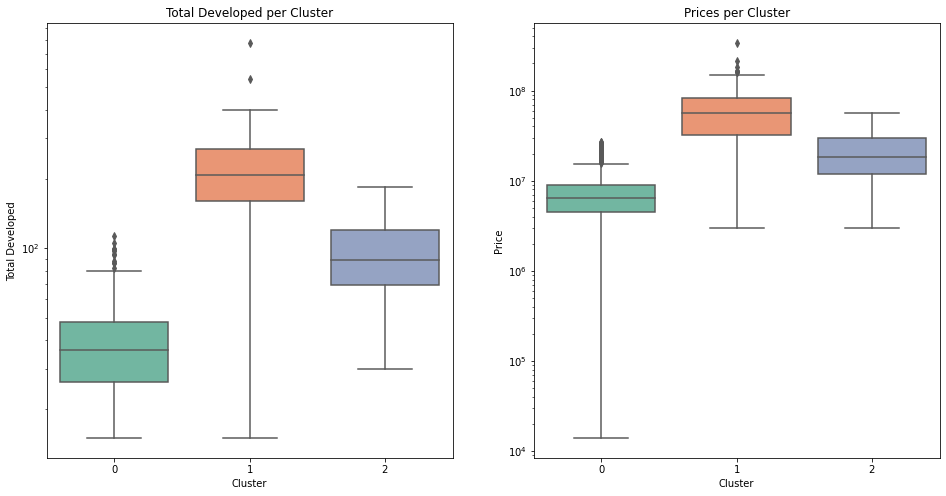

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.boxplot(data=gaussianDF, x='Cluster', y='Total Developed', palette='Set2', ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_title("Total Developed per Cluster")

sns.boxplot(data=gaussianDF, x='Cluster', y='Price', palette='Set2', ax=ax[1])
ax[1].set_yscale('log')
ax[1].set_title("Prices per Cluster")

By comparing the clusters through their boxplots, we can see the price and area ranges of each cluster. We can see that:
1. Cluster 0 - has the lowest prices and total developed area _(low-end condomeniums)_
2. Cluster 1 - has the highest prices and total developed area _(high-end condomeniums)_
3. Cluster 2 - has the middle prices and total developed area _(mid-end condomeniums)_

In [25]:
gaussianDF.groupby('Cluster').median()[['Price', 'Total Developed']]

,Price,Total Developed
Cluster,,
0,6374848.5,36.0
1,56004000.0,207.0
2,18350000.0,89.0


##### Total Bedrooms vs Showers

Text(0.5, 1.0, 'Showers per Cluster')

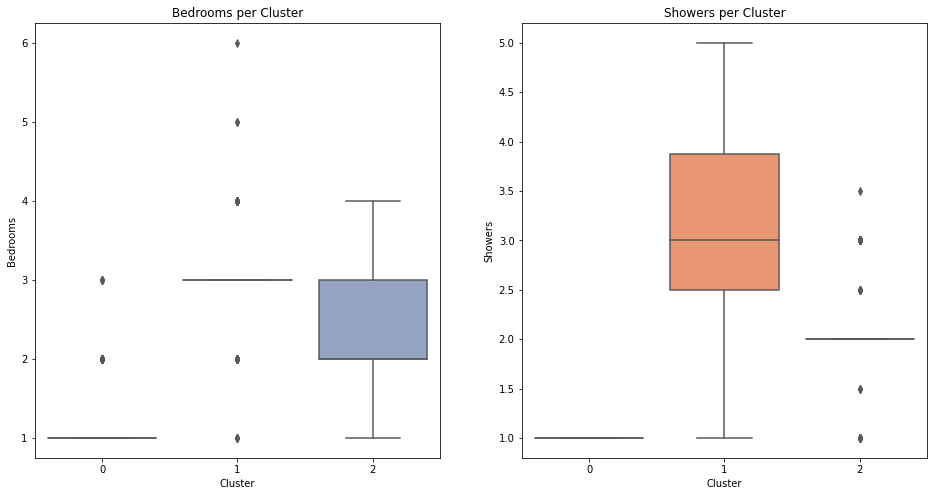

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.boxplot(data=gaussianDF, x='Cluster', y='Bedrooms', palette='Set2', ax=ax[0])
ax[0].set_title("Bedrooms per Cluster")

sns.boxplot(data=gaussianDF, x='Cluster', y='Showers', palette='Set2', ax=ax[1])
ax[1].set_title("Showers per Cluster")

By looking at the amount of bedrooms and showers of properties in each cluster, we can see that:
1. **Low-end** condomeniums typically only has _1 bedroom and 1 shower_.
2. **High-end** condomeniums typically have _3 bedrooms with 3-4 showers_.
3. **Mid-end** condomeniums typically have _2 bedrooms and showers_.

In [27]:
gaussianDF.groupby('Cluster').median()[['Bedrooms', 'Showers', 'Parking']]

,Bedrooms,Showers,Parking
Cluster,,,
0,1.0,1.0,0.0
1,3.0,3.0,2.0
2,2.0,2.0,1.0


##### Most Common Location per Cluster

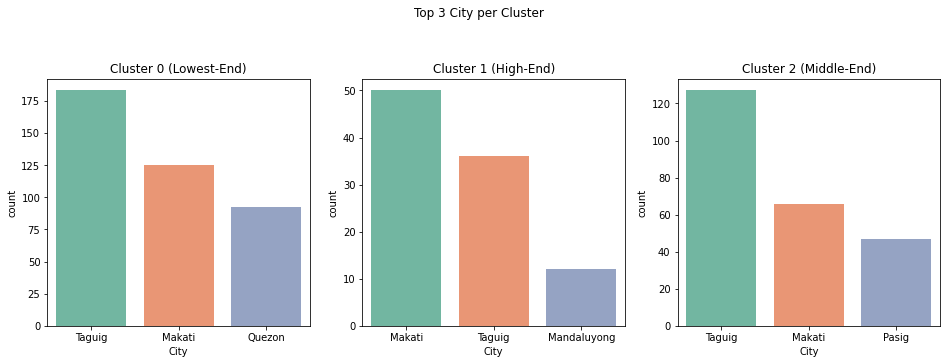

In [28]:
descriptions = ['Lowest-End', 'High-End', 'Middle-End']

fig = plt.figure(figsize=(16, 10))

fig.suptitle('Top 3 City per Cluster')

for cluster in range(3):
    fig.add_subplot(2, 3, cluster + 1)
    g = sns.countplot(x='City', data=gaussianDF[gaussianDF['Cluster'] == cluster], order=gaussianDF[gaussianDF['Cluster'] == cluster]['City'].value_counts().iloc[:3].index, palette="Set2")
    
    plt.title("Cluster %d (%s)" % (cluster, descriptions[cluster]))

We can see that the **Taguig** is the region with the **most the number of condomeniums listed for Low-end and Middle-end condomeniums**. With **Makati leading the High end condomeniums**. Along with Pasig, Quezon, Mandaluyong, and Cebu.

### Houses

#### Getting appropriate number of clusters
To get this, the elbow method will be utilized, however the values that will be used would be the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) scores of each components.

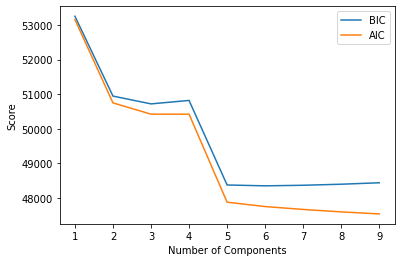

In [29]:
# check AIC and BIC as a function of number of components
N = np.arange(1, 10)
models = [GaussianMixture(n ,covariance_type='full',
          random_state=41).fit(house_data) for n in N]
plt.plot(N, [m.bic(house_data) for m in models], label='BIC')
plt.plot(N, [m.aic(house_data) for m in models], label='AIC')
plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('Score');

Both AIC, and BIC values shows us the **3** is the best value for n_components.

#### Defining the Model

<Figure size 864x576 with 0 Axes>

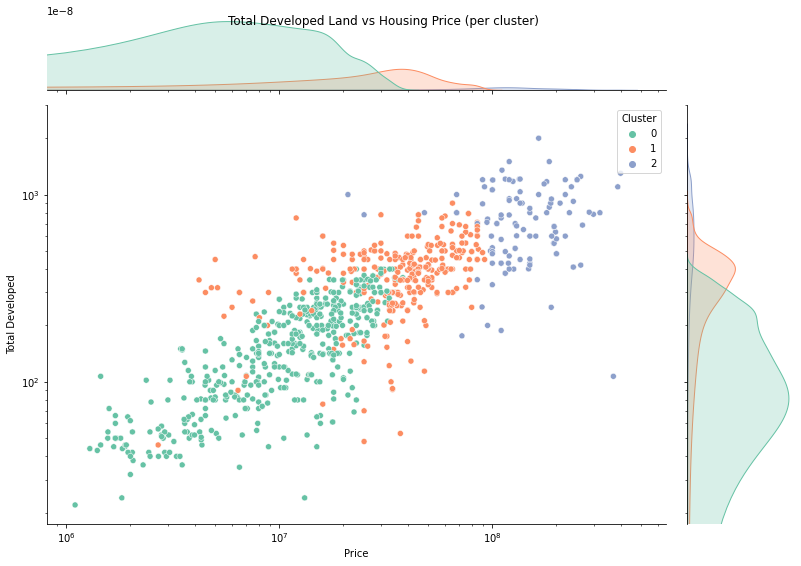

In [30]:
# define the model
model = GaussianMixture(n_components=3, covariance_type='full', random_state=41).fit(house_data)
# assign a cluster to each example
yhat = model.predict(house_data)

gaussianDF = house_df.copy()

gaussianDF['Cluster'] = yhat

_ = plt.figure(figsize=(12, 8))

g = sns.jointplot(data=gaussianDF, x="Price", y="Total Developed", hue="Cluster", palette='Set2')

g.fig.suptitle("Total Developed Land vs Housing Price (per cluster)")
g.fig.set_size_inches((12, 8)) 
g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')

By looking at the chart, we can once again see the relationship of the different clusters from one another based on their Total Area (in sqm) vs the Selling price of the properties within those clusters. However, Cluster 1 and Cluster 3 seems a bit similar.

#### Results per Cluster
##### Number of Items per Cluster

Text(0, 0.5, 'Count')

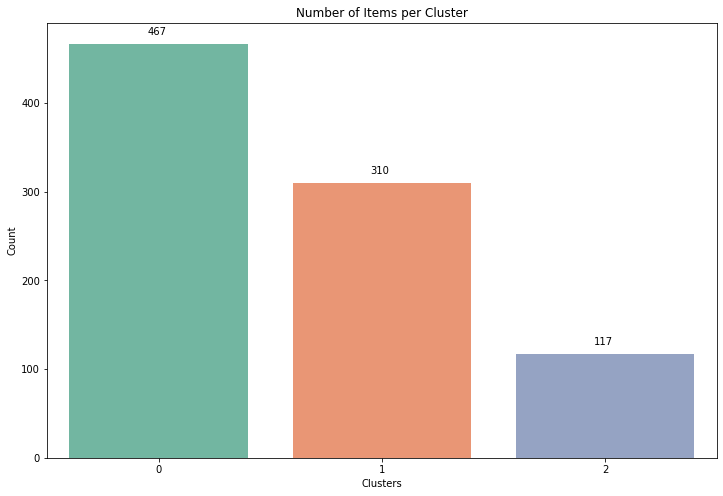

In [31]:
_ = plt.figure(figsize=(12, 8))

g = sns.countplot(x='Cluster', data=gaussianDF, palette='Set2')
for p in g.patches:
    g.annotate('{}'.format(p.get_height()), (p.get_x()+.35, p.get_height()+10))

plt.title("Number of Items per Cluster")
plt.xlabel("Clusters")
plt.ylabel("Count")

Unlike the condomeniums, houses has most properties at the Middle-end clusters (cluster 3). However, cluster 1 had the second most properties followed by cluster 2 then 0.

##### Total Developed vs Price per Cluster

Text(0.5, 1.0, 'Prices per Cluster')

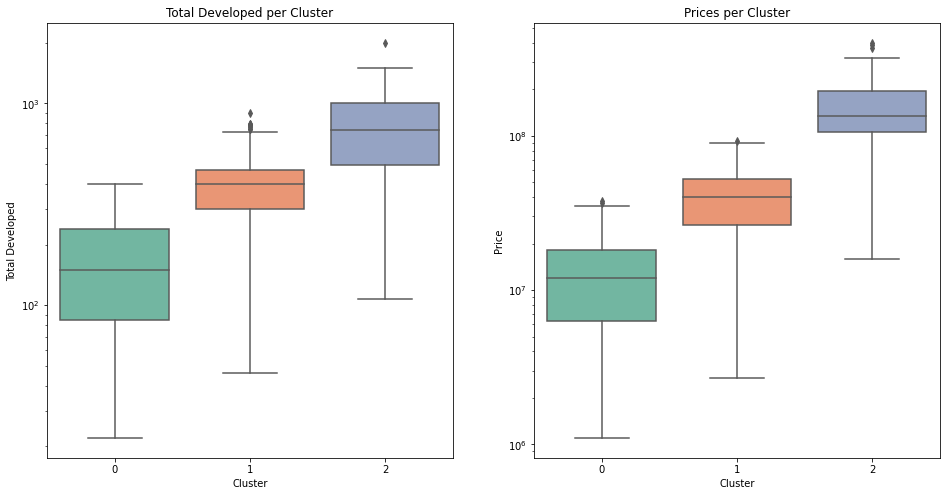

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.boxplot(data=gaussianDF, x='Cluster', y='Total Developed', palette='Set2', ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_title("Total Developed per Cluster")

sns.boxplot(data=gaussianDF, x='Cluster', y='Price', palette='Set2', ax=ax[1])
ax[1].set_yscale('log')
ax[1].set_title("Prices per Cluster")

By comparing the clusters through their boxplots, we can see the price and area ranges of each cluster. We can see that:
1. Cluster 0 - has lowest prices and total developed area  _(low-end houses)_
2. Cluster 1 - has the middle price and total developed area _(mid-end houses)_  
3. Cluster 2 - has the highest prices and total developed area _(high-end houses)_

In [33]:
gaussianDF.groupby('Cluster').median()[['Price', 'Total Developed']]

,Price,Total Developed
Cluster,,
0,12000000.0,150.0
1,40000000.0,400.0
2,135000000.0,740.0


##### Total Bedrooms vs Showers

Text(0.5, 1.0, 'Total Showers per Cluster')

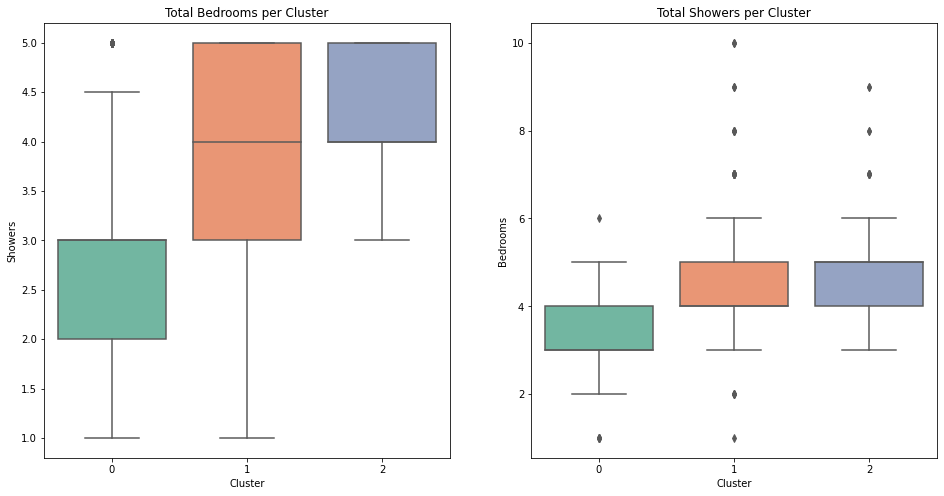

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.boxplot(data=gaussianDF, x='Cluster', y='Bedrooms', palette='Set2', ax=ax[1])
ax[0].set_title("Total Bedrooms per Cluster")

sns.boxplot(data=gaussianDF, x='Cluster', y='Showers', palette='Set2', ax=ax[0])
ax[1].set_title("Total Showers per Cluster")

By looking at the amount of bedrooms and showers of properties in each cluster, we can see that:
1. **Low-end** houses typically have _2-3 bedrooms with 3-4 showers_.
2. **Mid-end** houses typically have _3-5 bedrooms and 4-5 showers_.
3. **High-end** houses typically only has _4-5 bedroom with 4-5 showers_.

In [35]:
gaussianDF.groupby('Cluster').median()[['Bedrooms', 'Showers', 'Parking']]

,Bedrooms,Showers,Parking
Cluster,,,
0,3.0,3.0,2.0
1,4.0,4.0,3.0
2,5.0,4.0,4.0


##### Most Common Location per Cluster

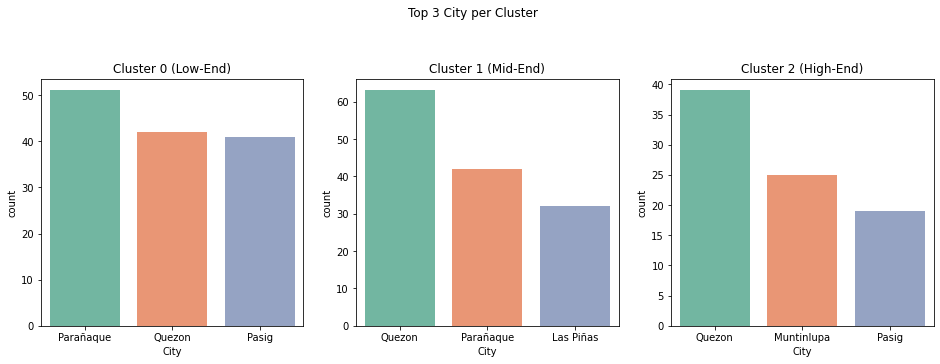

In [36]:
descriptions = ['Low-End', 'Mid-End', 'High-End']

fig = plt.figure(figsize=(16, 10))

fig.suptitle('Top 3 City per Cluster')

for cluster in range(3):
    fig.add_subplot(2, 3, cluster + 1)
    g = sns.countplot(x='City', data=gaussianDF[gaussianDF['Cluster'] == cluster], order=gaussianDF[gaussianDF['Cluster'] == cluster]['City'].value_counts().iloc[:3].index, palette="Set2")
    
    plt.title("Cluster %d (%s)" % (cluster, descriptions[cluster]))

For House properties, **Paranaque has the most Low-end houses**, while **Quezon has most houses within the Mid-end and High-end clusters**. 

## Overall Findings
For both models and samples, 3 clusters was the best choice based on the elbow method. Despite using other variables such as amount of `Bedrooms`, `Showers`, and `Parking Spaces`, the clusters can be distinguished from one another by plotting their `Price` and `Total Developed`.

By observing the difference in values of each cluster, we can see that these are separated based on how affordable and how big/luxurious these properties are. Which is why, all these clusters that are sets of 3 are classified into `Low-End`, `Mid-End`, and `High-End` properties. 

### Condos - KMeans vs GMM
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
.tg .tg-g1cc{border-color:#000000;color:#9a0000;text-align:center;vertical-align:top}
.tg .tg-0mw4{border-color:inherit;color:#9a0000;text-align:center;vertical-align:top}
.tg .tg-fymr{border-color:inherit;font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-hvqq{border-color:inherit;color:#333;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-7btt{border-color:inherit;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-qaub{border-color:inherit;color:#333;text-align:center;vertical-align:top}
</style>
<table class="tg" style="undefined;table-layout: fixed; width: 591px">
<colgroup>
<col style="width: 86px">
<col style="width: 91px">
<col style="width: 63px">
<col style="width: 97px">
<col style="width: 88px">
<col style="width: 83px">
<col style="width: 83px">
</colgroup>
<thead>
  <tr>
    <th class="tg-0pky" rowspan="2"></th>
    <th class="tg-g1cc" colspan="9">KMeans (Median)</th>
  </tr>
  <tr>
    <th class="tg-g1cc">Total Items</th>
    <th class="tg-g1cc">Price</th>
    <th class="tg-0mw4"> Total Developed</th>
    <th class="tg-0mw4">Bedrooms</th>
    <th class="tg-0mw4">Showers</th>
    <th class="tg-0mw4">Parking Spaces</th>
    <th class="tg-0mw4">Top 1 City</th>
    <th class="tg-0mw4">Top 2 City</th>
    <th class="tg-0mw4">Top 3 City</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0pky">Low-End</td>
    <td class="tg-g1cc">1148</td>
    <td class="tg-g1cc">7.5M</td>
    <td class="tg-0mw4">43.0</td>
    <td class="tg-0mw4">1.0</td>
    <td class="tg-0mw4">1.0</td>
    <td class="tg-0mw4">1.0</td>
    <td class="tg-0mw4">Taguig</td>
    <td class="tg-0mw4">Makati</td>
    <td class="tg-0mw4">Pasig</td>
  </tr>
  <tr>
    <td class="tg-0pky">Mid-End</td>
    <td class="tg-0mw4">198</td>
    <td class="tg-0mw4">42M</td>
    <td class="tg-0mw4">155.5</td>
    <td class="tg-0mw4">3.0</td>
    <td class="tg-0mw4">3.0</td>
    <td class="tg-0mw4">2.0</td>
    <td class="tg-0mw4">Makati</td>
    <td class="tg-0mw4">Taguig</td>
    <td class="tg-0mw4">Mandaluyong</td>
  </tr>
  <tr>
    <td class="tg-0pky">High-End</td>
    <td class="tg-g1cc">24</td>
    <td class="tg-g1cc">142M</td>
    <td class="tg-0mw4">304.0</td>
    <td class="tg-0mw4">3.0</td>
    <td class="tg-0mw4">4.0</td>
    <td class="tg-0mw4">3.0</td>
    <td class="tg-0mw4">Taguig</td>
    <td class="tg-0mw4">Makati</td>
    <td class="tg-0mw4">Pasig</td>
  </tr>
  <tr>
    <th class="tg-fymr" rowspan="2"></th>
    <th class="tg-hvqq" colspan="9">GMM (Median)</th>
  </tr>
  <tr>
    <th class="tg-hvqq">Total Items</th>
    <th class="tg-hvqq">Price</th>
    <th class="tg-7btt"> Total Developed</th>
    <th class="tg-7btt">Bedrooms</th>
    <th class="tg-7btt">Showers</th>
    <th class="tg-7btt">Parking Spaces</th>
    <th class="tg-0mw4">Top 1 City</th>
    <th class="tg-0mw4">Top 2 City</th>
    <th class="tg-0mw4">Top 3 City</th>
  </tr>
  <tr>
    <td class="tg-0pky">Low-End</td>
    <td class="tg-qaub">838</td>
    <td class="tg-qaub">6.37M</td>
    <td class="tg-c3ow">36.0</td>
    <td class="tg-c3ow">1.0</td>
    <td class="tg-c3ow">1.0</td>
    <td class="tg-c3ow">0.0</td>
    <td class="tg-c3ow">Taguig</td>
    <td class="tg-c3ow">Makati</td>
    <td class="tg-c3ow">Quezon</td>
  </tr>
  <tr>
    <td class="tg-0pky">Mid-End</td>
    <td class="tg-c3ow">390</td>
    <td class="tg-c3ow">18.35M</td>
    <td class="tg-c3ow">89.0</td>
    <td class="tg-c3ow">2.0</td>
    <td class="tg-c3ow">2.0</td>
    <td class="tg-c3ow">1.0</td>
    <td class="tg-c3ow">Taguig</td>
    <td class="tg-c3ow">Makati</td>
    <td class="tg-c3ow">Pasig</td>
  </tr>
  <tr>
    <td class="tg-0pky">High-End</td>
    <td class="tg-qaub">142</td>
    <td class="tg-qaub">56M</td>
    <td class="tg-c3ow">207.0</td>
    <td class="tg-c3ow">3.0</td>
    <td class="tg-c3ow">3.0</td>
    <td class="tg-c3ow">2.0</td>
    <td class="tg-c3ow">Makati</td>
    <td class="tg-c3ow">Taguig</td>
    <td class="tg-c3ow">Mandaluyong</td>
  </tr>
</tbody>
</table>

### Houses - KMeans vs GMM
<table style="undefined;table-layout: fixed; width: 591px">
<colgroup>
<col style="width: 86px">
<col style="width: 91px">
<col style="width: 63px">
<col style="width: 97px">
<col style="width: 88px">
<col style="width: 83px">
<col style="width: 83px">
</colgroup>
<thead>
  <tr>
    <th rowspan="2"></th>
    <th colspan="9">KMeans (Median)</th>
  </tr>
  <tr>
    <th>Total Items</th>
    <th>Price</th>
    <th> Total Developed</th>
    <th>Bedrooms</th>
    <th>Showers</th>
    <th>Parking Spaces</th>
    <th>Top 1 City</th>
    <th>Top 2 City</th>
    <th>Top 3 City</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>Low-End</td>
    <td>722</td>
    <td>17M</td>
    <td>220.0</td>
    <td>4.0</td>
    <td>3.0</td>
    <td>2.0</td>
    <td>Paranaque</td>
    <td>Quezon</td>
    <td>Pasig</td>
  </tr>
  <tr>
    <td>Mid-End</td>
    <td>129</td>
    <td>90M</td>
    <td>540.0</td>
    <td>5.0</td>
    <td>4.0</td>
    <td>4.0</td>
    <td>Quezon</td>
    <td>Muntinlupa</td>
    <td>Pasig</td>
  </tr>
  <tr>
    <td>High-End</td>
    <td>43</td>
    <td>208M</td>
    <td>805.0</td>
    <td>5.0</td>
    <td>5.0</td>
    <td>4.0</td>
    <td>Quezon</td>
    <td>Muntinlupa</td>
    <td>Pasig</td>
  </tr>
  <tr>
    <th rowspan="2"></th>
    <th colspan="9">GMM (Median)</th>
  </tr>
  <tr>
    <th>Total Items</th>
    <th>Price</th>
    <th> Total Developed</th>
    <th>Bedrooms</th>
    <th>Showers</th>
    <th>Parking Spaces</th>
    <th>Top 1 City</th>
    <th>Top 2 City</th>
    <th>Top 3 City</th>
  </tr>
  <tr>
    <td>Low-End</td>
    <td>467</td>
    <td>12M</td>
    <td>150.0</td>
    <td>3.0</td>
    <td>3.0</td>
    <td>2.0</td>
    <td>Paranaque</td>
    <td>Quezon</td>
    <td>Pasig</td>
  </tr>
  <tr>
    <td>Mid-End</td>
    <td>310</td>
    <td>40M</td>
    <td>400.0</td>
    <td>4.0</td>
    <td>4.0</td>
    <td>3.0</td>
    <td>Quezon</td>
    <td>Paranaque</td>
    <td>Las Pinas</td>
  </tr>
  <tr>
    <td>High-End</td>
    <td>117</td>
    <td>135M</td>
    <td>740.0</td>
    <td>5.0</td>
    <td>4.0</td>
    <td>4.0</td>
    <td>Quezon</td>
    <td>Muntinlupa</td>
    <td>Pasig</td>
  </tr>
</tbody>
</table>

### Analysis
- As observed, the median values using the **GMM** clustering method are generally lower compared to the **KMeans** method across the different clusters.  
- Compared to **KMeans**, the properties in **GMM** are generally more distributed for both samples.
- The different clusters **provide good categorization of the property types** based on the number of shower, bedrooms, and parking spaces along with the price and total developed.
- Houses generally have more bedrooms and showers than condominiums for each cluster.
- Despite being separated into clusters based on the numerical data without the location information, the clusters were able to separate the different cities fairly well for both houses and condos (there is consistency with the cities of the clusters for both methods)
- Overall, there isn't much difference between KMeans vs GMM aside from their distribution, and median values.
- However, **GMM** seems like the better model as it is __distributed more equally__ compared to **KMeans**

# RESEARCH QUESTION

## What are the features with the highest correlation to price?

In [37]:
df = pd.read_json('cleaned_data.json', orient='columns')

Text(0.5, 1.0, 'Heatmap of Correlation between Features')

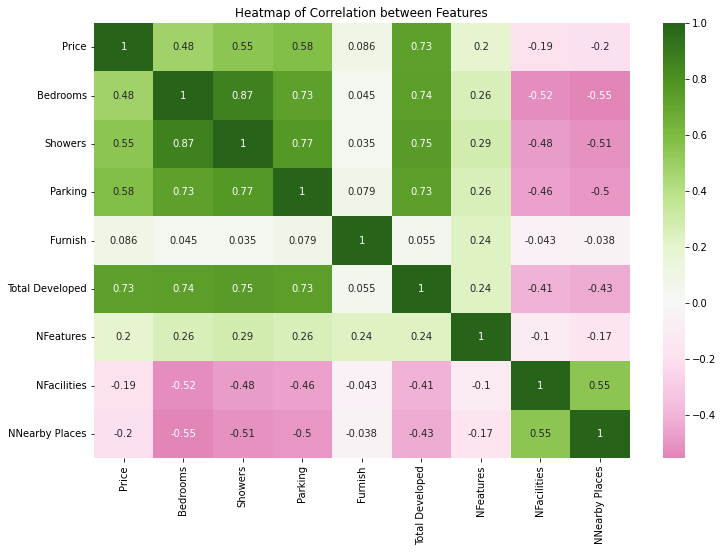

In [38]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, center=0, cmap='PiYG')
plt.title('Heatmap of Correlation between Features')

Results of heatmap - Highest correlation to price:  
   
    Top 1:    Parking
    
    Top 2/3:  Showers / Total Developed

### To further analyze the correlation between price and parking, showers, and total developed, we utilized pairplots to see the relationships between features in the heatmap


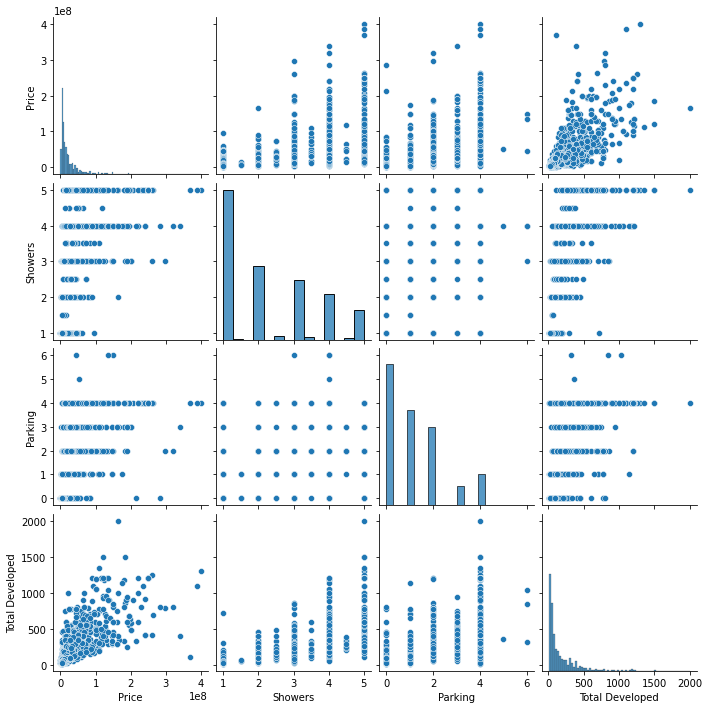

In [39]:
sns.pairplot(data = df[['Price', 'Showers', 'Parking', 'Total Developed']])

The price and total developed is positively correlated, valued at 0.58. The other features such as Bedrooms, Showers, Parking and Number of Features are a bit misleading because, even if it has a positive correlation, the scatter plot shows no trend. The only one with the trend would be Total Developed and the Price of the property which makes a lot of sense. It can be seen that the as the total developed area in square meter gets higher, the price of the properties becomes higher.

# CONCLUSIONS
- Housing Prices are **prone to outliers** mainly due to **incorrect pricing from human error** and **unfair sellers**
- The geographical locations of the property listings are not balanced. Most properties can be found within Luzon as an island and NCR as a Region, and the difference to all the other islands and regions was big. This may be due to lack of website exposure in other cities in the other islands of the country compared to Luzon.
- The price and total developed area are positively correlated. Which means that as the total developed area goes up, the price also goes up. 
- By separating condos and houses into clusters, we can help a client decide what property to buy by providing them the clusters that fit their needs and wants (e.g., size, number of bedrooms, type of property, and budget). The clusters give the customers an idea on what to expect for low-tier, mid-tier, and high-tier condos and houses. In a real life use-case, this will be mainly determined by the budget and preference of the buyer.
- Houses are generally more expensive than condos, with more total developed area, bedrooms, showers, and parking space.
- GMM seems to be the better model compared to KMeans as is it distributed more evenly, but aside from that, there is not much difference between the 2.